In [1]:
!pip install diffusers transformers torch torchvision matplotlib




[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import matplotlib.pyplot as plt


In [3]:
def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return np.linspace(beta_start, beta_end, timesteps)


In [4]:
def get_alpha_values(beta):
    alphas = 1.0 - beta
    alphas_cumprod = np.cumprod(alphas)
    return alphas, alphas_cumprod


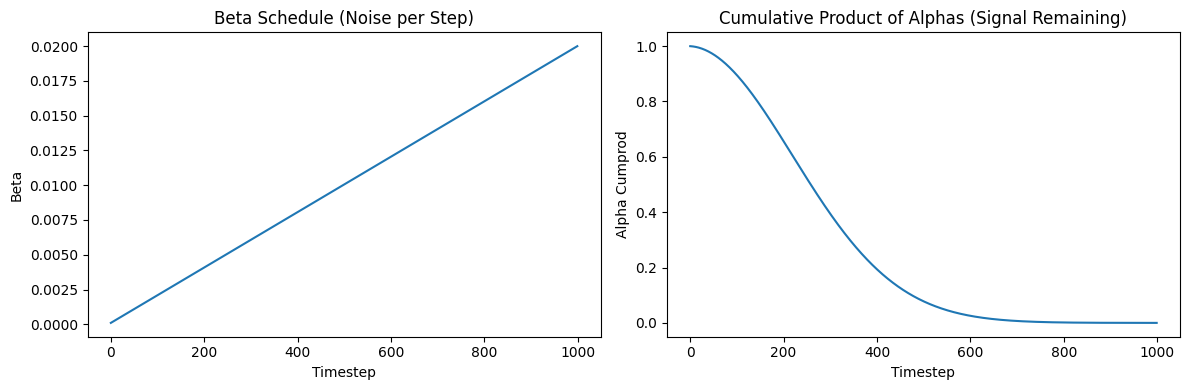

In [5]:
timesteps = 1000
beta = linear_beta_schedule(timesteps)
alphas, alphas_cumprod = get_alpha_values(beta)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(beta)
plt.title("Beta Schedule (Noise per Step)")
plt.xlabel("Timestep")
plt.ylabel("Beta")

plt.subplot(1, 2, 2)
plt.plot(alphas_cumprod)
plt.title("Cumulative Product of Alphas (Signal Remaining)")
plt.xlabel("Timestep")
plt.ylabel("Alpha Cumprod")

plt.tight_layout()
plt.show()


In [6]:
def forward_diffusion_sample(x0, t, alphas_cumprod):
    noise = np.random.randn(*x0.shape)
    alpha_t = alphas_cumprod[t]
    return np.sqrt(alpha_t) * x0 + np.sqrt(1 - alpha_t) * noise, noise


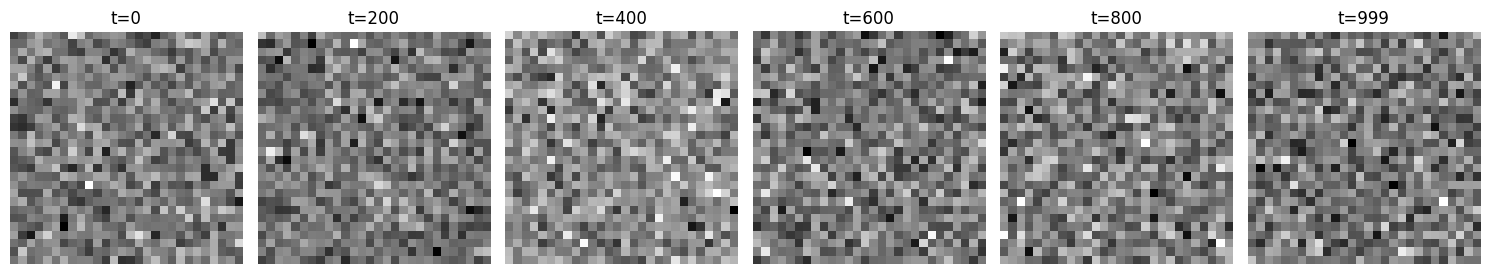

In [7]:
x0 = np.ones((28, 28))  # A simple white square
timesteps_to_view = [0, 200, 400, 600, 800, 999]

plt.figure(figsize=(15, 3))
for i, t in enumerate(timesteps_to_view):
    xt, _ = forward_diffusion_sample(x0, t, alphas_cumprod)
    plt.subplot(1, len(timesteps_to_view), i + 1)
    plt.imshow(xt, cmap='gray')
    plt.title(f"t={t}")
    plt.axis("off")

plt.tight_layout()
plt.show()


#  Load the Pipeline    

We're loading the Stable Diffusion model.

We don't need the text encoder or U-Net for now — just the scheduler (to apply noise) and vae (to work in latent space).

This is the same VAE and scheduler used during generation.

In [19]:
from diffusers import StableDiffusionPipeline


# Load the pipeline (just the scheduler & VAE for now)
pipe = StableDiffusionPipeline.from_pretrained("/opt/models/base-models/dreamshaper_v4")
pipe.to("cuda")
scheduler = pipe.scheduler
vae = pipe.vae




Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/home/albert/miniconda3/lib/python3.11/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


# Load and Encode a Real Image

The VAE works in a normalized [-1, 1] space.

The image must be resized to 512x512 (expected input).

We convert it into a tensor and move it to GPU.

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torchvision.transforms as T
import torch

image = Image.open("images.png").convert("RGB").resize((512, 512))

# Convert image to latent using the VAE
preprocess = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5], [0.5]),
])
image_tensor = preprocess(image).unsqueeze(0).to("cuda")  # shape: [1, 3, 512, 512]

# Encode to latent
latents = vae.encode(image_tensor * 0.18215).latent_dist.sample()  # scale = 0.18215 (as used in SD)
latents = latents * 0.18215
image

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 

We encode the image into a latent vector using the VAE.

The factor 0.18215 is a scaling factor used in Stable Diffusion to match the latent distribution learned during training.

In [ ]:
latents

tensor([[[[ 0.7034,  0.6009,  0.6817,  ...,  0.6043,  0.5518,  0.4989],
          [ 0.5303,  0.5605,  0.5624,  ...,  0.4996,  0.4066,  0.4634],
          [ 0.6197,  0.5106,  0.5933,  ...,  0.5431,  0.4473,  0.2804],
          ...,
          [ 0.5968,  0.5517,  0.5824,  ...,  0.5391,  0.4379,  0.2950],
          [ 0.4989,  0.3613,  0.4596,  ...,  0.4196,  0.3243,  0.2668],
          [ 0.5529,  0.4436,  0.4318,  ...,  0.3632,  0.3506,  0.2098]],

         [[ 0.0018,  0.0368,  0.0036,  ..., -0.0159, -0.0710,  0.2402],
          [-0.1376, -0.0635, -0.0546,  ..., -0.1154, -0.1790,  0.3459],
          [-0.0934, -0.0600, -0.0849,  ..., -0.1514, -0.1282,  0.2776],
          ...,
          [-0.1138, -0.0628, -0.0859,  ..., -0.1426, -0.1143,  0.2969],
          [-0.0478, -0.0339, -0.0618,  ..., -0.1150, -0.0522,  0.3237],
          [ 0.0097,  0.0865,  0.0714,  ...,  0.0053,  0.1162,  0.4150]],

         [[ 0.0206,  0.4084,  0.4186,  ...,  0.3693,  0.3729,  0.5696],
          [ 0.3611,  0.7545,  

# Simulate Adding Noise at Various Timesteps

This simulates what the forward diffusion process does during training.

The scheduler handles the math behind how much noise to add at each timestep.

In [ ]:
def add_noise(latents, noise, timesteps, scheduler):
    return scheduler.add_noise(latents, noise, timesteps)

# Choose timesteps
timesteps_to_plot = [0, 50, 200, 400, 600, 999]
noise = torch.randn_like(latents)
noised_latents = [add_noise(latents, noise, torch.tensor([t], device="cuda"), scheduler) for t in timesteps_to_plot]

We pick a few timesteps (t=0 to t=999) to show the progression.

Add noise to the latent image at each of these steps using the scheduler's beta schedule.

The latents themselves are not images.

We must decode them using the VAE decoder to see what the model sees at each timestep.

In [ ]:
def decode_latents(latents):
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        images = vae.decode(latents).sample
    images = (images / 2 + 0.5).clamp(0, 1)
    return images.cpu().permute(0, 2, 3, 1).numpy()

decoded_images = [decode_latents(latent)[0] for latent in noised_latents]


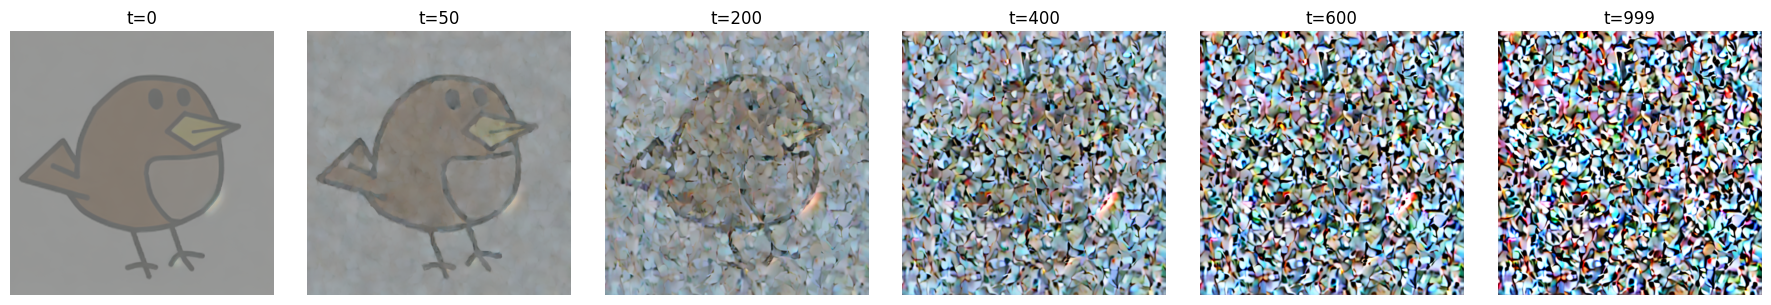

In [ ]:
plt.figure(figsize=(18, 3))
for i, img in enumerate(decoded_images):
    plt.subplot(1, len(decoded_images), i+1)
    plt.imshow(img)
    plt.title(f"t={timesteps_to_plot[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


A series of images from t=0 to t=999.

The image becomes more and more noisy — simulating how the model gets trained to denoise this step-by-step.